# PHY4268 Tutorial 4 - Qiskit VQE with active space

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
May 2024

A la fin de ce tutoriel, l'apprenant doit être capable d'utiliser Qiskit-nature pour
1. calculer l'énergie de l'état fondamental d'un Hamiltonien quelconque;
2. définir l'espace actif d'un système moléculaire autour du niveau de Fermi (Niveau HOMO-LUMO);
3. et calculer l'énergie de l'état fondamental y afférent.


## Hamiltonien quelconque

On considère l'Hamiltonien 
$$\mathtt{H} = 0.4\mathbb{I}\mathtt{X} + 0.6\mathbb{I}\mathtt{Z} + 0.8\mathtt{XY}$$

Pour un $|\psi\rangle$ donné nous voulons évaluer la valeur moyenne de cet Hamiltonien :

$$\langle \mathtt{H} \rangle = \langle \psi |\mathtt{H}| \psi \rangle = 0.4 \langle \psi | \mathbb{I}\mathtt{X} |\psi \rangle + 0.6 \langle \psi | \mathbb{I}\mathtt{Z} | \psi \rangle + 0.8 \langle \psi | \mathtt{XY} | \psi \rangle.$$

Comme on peut voir la valeur moyenne $\langle\mathtt{H} \rangle$ pourrait être calculée en ajoutant les valeurs moyennes de ses parties (termes de Pauli). L'algorithme fait exactement cela. Il construit un circuit quantique pour chaque terme de Pauli et calcule la valeur moyenne du terme de Pauli correspondant. Ensuite, l'algorithme additionne toutes les valeurs moyennes calculées des termes de Pauli et obtient la valeur moyenne de $\mathtt{H}$.


In [14]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import NumPyMinimumEigensolver

H = SparsePauliOp.from_list([("IX", 0.4), ("IZ", 0.6), ("XY", 0.8)])
print(H)

exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
print(f'\n The exact ground state energy is: {exact_result.eigenvalue}')

SparsePauliOp(['IX', 'IZ', 'XY'],
              coeffs=[0.4+0.j, 0.6+0.j, 0.8+0.j])

 The exact ground state energy is: -1.0770329614269007


Si on a un Hamiltonien 
$$\mathtt{H} = a\mathbb{I} + b\mathtt{Z} + c\mathtt{X} + d\mathtt{Y},\qquad a,b,c,d\in\mathbb{R},$$
il faut faire appel à des nombres arbitraires pour a, b, c et d.

In [13]:
from numpy import random

a, b, c, d = 10*random.sample(4)

H = SparsePauliOp.from_list([("I", a), ("Z", b), ("X", c), ("Y", d)])

print(H)
exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
print(f'\n The exact ground state energy is: {exact_result.eigenvalue}')

SparsePauliOp(['I', 'Z', 'X', 'Y'],
              coeffs=[4.93871228+0.j, 2.86785997+0.j, 2.21273705+0.j, 4.02410484+0.j])

 The exact ground state energy is: -0.47555090709633374


## Molécule d'eau

### Hamiltionien électronique

![Water_HF_references](Graphics/Water_HF_references.png)

La molécule d'eau a un nombre total de dix électrons. Le déterminant de Slater résultant de l'occupation des cinq premières orbitales moléculaires d'énergie la plus basse avec deux électrons *appariés* dans chaque orbitale, l'un avec spin-up et l'autre avec spin-down, est dit être un état HF à couche fermée avec une *multiplicité de spin=1*. Alternativement, si nous définissons une occupation où les quatre premières orbitales sont doublement occupées et les deux suivantes sont occupées individuellement par des électrons *non appariés* avec spin-up, on dit qu'il s'agit d'un état HF à couche ouverte avec une *multiplicité de spin=3*.

Il n'est pas superflue de rappeler à nouveau ce qui suit.

* La multiplicité, que nous pouvons définir comme $(N_{\rm unpaired}^e + 1)$ avec $N_{\rm unpaired}^e$ le nombre d'électrons non appariés, détermine l'occupation des orbitales moléculaires dans les calculs HF. 

* Les orbitales moléculaires sont généralement représentées comme une combinaison linéaire de
**orbitales atomiques**. Les coefficients de d'expansion dans la base atomique sont
calculé en utilisant la méthode de Hartree-Fock (HF). Dans l'approximation HF, chaque électron de la molécule est traité comme une particule **indépendante** qui se déplace sous l'influence du Coulomb potentiel dû aux noyaux, et un champ moyen généré par tous les autres
électrons. Les coefficients optimisés sont précisément ce dont on a besoin pour
construire le Hamiltonien de la seconde quantification.

### Active-Space reduction

En général, les méthodes de corrélation d'électrons post-Hartree-Fock étendent la fonction d'état de la molécule autour de la solution Hartree-Fock, en ajoutant des déterminants de Slater, communément appelés **configurations**, qui résultent de l'excitation des électrons des orbitales HF occupées vers les orbitales inoccupées. Malgré le fait qu'il existe différentes techniques pour tronquer cette expansion, le nombre de configurations augmente de manière combinatoire avec le nombre d'électrons et de fonctions de base et la tâche de trouver les coefficients d'expansion de la fonction d'état devient numériquement insoluble si nous voulons inclure l'ensemble complet des orbitales moléculaires. .

Afin de contourner l'explosion combinatoire, nous pouvons créer un espace actif en classant les orbitales moléculaires en orbitales doublement occupées, actives et externes :

* les orbitales doublement occupées (**core orbitals**) sont toujours occupées par deux électrons;
* les orbitales actives (**valence orbitals**) peuvent être occupées par zéro, un ou deux électrons.
* les orbitales externes (**virtual orbitals**) ne sont jamais occupées.

![Sketch_active_space](Graphics/Sketch_active_space.png)

Dans cette approximation, un certain nombre d'*électrons actifs* peuvent peupler les *orbitales actives* à partir desquelles nous pouvons générer un espace de taille finie de déterminants de Slater.

**Note**</br>
Le nombre de *spin-orbitales actives* détermine le *nombre de qubits* requis pour effectuer des simulations quantiques de la structure électronique de la molécule.

Pour le cas de la molécule d'eau décrite à l'aide d'un ensemble de base minimal, nous avons un total de dix électrons occupant les cinq premières des sept orbitales moléculaires dans l'état de référence HF. 

Avec `qiskit_nature.second_q.transformers.ActiveSpaceTransformer`, la réduction se fait en calculant l'opérateur de Fock inactif qui est défini comme
$$ F^I_{pq} = h_{pq} + \sum_i (2 g_{iipq} - g_{iqpi}),
$$
et l'énergie inactive qui est donnée par
$$ E^I = \sum_j h_{ji} + F^I_{jj} = \frac12 \sum_{ij} \Big(h_{ij} + F^I_{jj}\Big) D^I_{ij} ,$$
où $i$ et $j$ itèrent sur les orbitales inactives. En utilisant l'opérateur de Fock inactif à la place des intégrales à un électron, la description de l'espace actif contient un potentiel effectif généré par les électrons inactifs. Par conséquent, cette méthode permet l'exclusion des électrons non centraux tout en conservant une description de haute qualité du système.

In [8]:
from qiskit_nature.second_q.drivers import PySCFDriver 

H2O_driver = PySCFDriver(
    atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0',
    basis="sto-3g"
)

H2O_problem = H2O_driver.run()
H2O_hamiltonian = H2O_problem.hamiltonian
H2O_coefficients = H2O_hamiltonian.electronic_integrals
H2O_fermionic_op = H2O_hamiltonian.second_q_op()


In [9]:
print(f'Molecule strcuture: {H2O_problem.molecule}')
print(f'Reference energy: {H2O_problem.reference_energy}')
print(f'Nuclear repulsion energy: {H2O_problem.nuclear_repulsion_energy}')
print(f'Number of particules: {H2O_problem.num_particles}')
print(f'Number of spatial orbitals: {H2O_problem.num_spatial_orbitals}')
print(f'Number of molecular orbitals: {H2O_problem.num_spin_orbitals}')
print(f'Number of alpha electrons: {H2O_problem.num_alpha}')
print(f'Number of beta electrons: {H2O_problem.num_beta}')
print(f'Occupations of the alpha-spin orbitals: {H2O_problem.orbital_occupations}')


Molecule strcuture: Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Bohr
	Geometry:
		O	(0.0, 0.0, 0.0)
		H	(1.430522676295752, 1.1073795089951262, 0.0)
		H	(-1.430522676295752, 1.1073795089951262, 0.0)
	Masses:
		O	16
		H	1
		H	1
Reference energy: -74.96294665653873
Nuclear repulsion energy: 9.193913160623385
Number of particules: (5, 5)
Number of spatial orbitals: 7
Number of molecular orbitals: 14
Number of alpha electrons: 5
Number of beta electrons: 5
Occupations of the alpha-spin orbitals: [1. 1. 1. 1. 1. 0. 0.]


In [10]:
print(f"HOMO and LUMO indexes are (Fermi surface) {H2O_problem.num_alpha-1, H2O_problem.num_alpha}")
print(f"HOMO and LUMO energies are {H2O_problem.orbital_energies[H2O_problem.num_alpha-1],H2O_problem.orbital_energies[H2O_problem.num_alpha]}")
print(f"HOMO-LUMO gap is {abs(H2O_problem.orbital_energies[H2O_problem.num_alpha-1]-H2O_problem.orbital_energies[H2O_problem.num_alpha])}")


HOMO and LUMO indexes are (Fermi surface) (4, 5)
HOMO and LUMO energies are (-0.39124236612641816, 0.6055762144355992)
HOMO-LUMO gap is 0.9968185805620173


### 1.9.3. <a id='toc1_9_3_'></a>[`FreezeCoreTransformer`](#toc0_)

Ce transformateur vous offre un moyen très simple de geler les _core orbitales_ du système moléculaire. Il nécessite que votre problème contienne l'attribut `.molecule` à partir duquel il peut extraire les informations atomiques nécessaires pour effectuer cette réduction d'espace de Hilbert.

Appliquons `qiskit_nature.second_q.transformers.FreezeCoreTransforme` à notre molécule qui, dans ce cas, supprimera la seule orbitale d'énergie la plus basse (réduisant le nombre total d'orbitales spatiales de 7 à 6) et supprimant également les deux électrons de l'intérieur de cette orbitale (comme reflété par le nombre modifié de particules).

In [23]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

fc_transformer = FreezeCoreTransformer()

fc_H2O_problem = fc_transformer.transform(H2O_problem)
print(f'Number of particules with FC: {fc_H2O_problem.num_particles}')
print(f'Number of spatial orbitals with FC: {fc_H2O_problem.num_spatial_orbitals}')


Number of particules with FC: (4, 4)
Number of spatial orbitals with FC: 6


Notez que cette transformation se traduira par un décalage d'énergie constant résultant de la suppression des électrons du noyau. Ce décalage est enregistré à l'intérieur de l'attribut `constants`" de l'Hamiltonien.

In [24]:
print(fc_H2O_problem.hamiltonian.constants)

{'nuclear_repulsion_energy': 9.193913160623385, 'FreezeCoreTransformer': -60.66177520598532}


Vous pouvez fournir une liste d'indices orbitaux (se rappeler qu'on commence par 0) qui doivent être supprimés du système.

> **Remarque :** Ces orbitales *doivent* être inoccupées, sinon vous subirez une erreur importante dans votre calcul. Vous devez absolument savoir quelles orbitales vous supprimez, car la suppression des mauvaises orbitales peut toujours entraîner de grandes erreurs si la dynamique des systèmes est modifiée de manière significative.

In [25]:
fc_H2O_transformer = FreezeCoreTransformer(remove_orbitals=[5, 6])

fc_H2O_problem = fc_H2O_transformer.transform(H2O_problem)
print(fc_H2O_problem.num_particles)
print(fc_H2O_problem.num_spatial_orbitals)

(4, 4)
6


### `ActiveSpaceTransformer`

Ce transformateur généralise la réduction de l'espace de Hilbert qui est effectuée par le `FreezeCoreTransformer`. En termes simples, il vous permet de spécifier un _active space_ en sélectionnant le nombre d'électrons actifs et le nombre d'orbitales spatiales actives. Selon ces paramètres, l'espace actif sera choisi autour du niveau de Fermi.

L'espace actif peut être configuré de l'une des manières suivantes via l'initialiseur :

- lorsque seuls ``num_electrons`` et ``num_spatial_orbitals`` sont spécifiés, ces entiers indiquent respectivement le nombre d’électrons actifs et d’orbitales. L'espace actif sera puis être choisi autour du niveau de Fermi, ce qui donne un choix unique pour n'importe quelle paire de nombres. Néanmoins, les critères suivants doivent être remplis :

   * le nombre restant d'électrons inactifs doit être un nombre pair et positif; 
   * le nombre d'orbitales actives ``num_spatial_orbitals`` ne doit pas dépasser le nombre total d'orbitales moins le nombre d'orbitales occupées par les électrons inactifs;

- lorsque ``num_electrons`` est un tuple, cela doit indiquer le nombre de spins alpha et bêta électrons, respectivement. Les mêmes exigences que celles énumérées précédemment doivent être remplies;
- enfin, il est possible de sélectionner un ensemble personnalisé d'orbitales actives via leurs indices en utilisant ``active_orbitals``. Ceci permet de sélectionner un espace actif qui n'est pas placé autour du niveau de Fermi comme décrit dans le premier cas ci-dessus. Lorsque vous utilisez cet argument de mot-clé, les critères suivants doivent être remplis *en plus* de ceux énumérés ci-dessus :

   * la longueur de `active_orbitals` doit être égale à ``num_spatial_orbitals``. Noter que qiskit-nature de  **déduit pas** le nombre d'orbitales actives à partir de cette liste d'indices !

   * lors de l'utilisation d'un tuple de listes pour indiquer les indices orbitaux de spin alpha et bêta séparément, les deux listes doivent remplir le critère précédent;

   * le plus grand indice orbital ne peut **pas** dépasser le ``num_spatial_orbitals`` disponible.

In [11]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

# We want to reduce it to an active space of 2 electrons in 2 orbitals (HOMO, LUMO)
as_transformer = ActiveSpaceTransformer(2, 2) # ActiveSpaceTransformer(num_electrons, num_spatial_orbitals) 

H2O_as_problem = as_transformer.transform(H2O_problem)
print(H2O_as_problem.num_particles)
print(H2O_as_problem.num_spatial_orbitals)

(1, 1)
2


`qiskit_nature.second_q.transformers.ActiveSpaceTransformer` permet aussi de spécifier manuellement les indices des orbitales actives. Cela vous permet de sélectionner manuellement des _active space_ qui ne se trouvent pas en permanence autour du niveau de Fermi.

In [17]:
as_transformer = ActiveSpaceTransformer(2, 2, active_orbitals=[3, 6])

H2O_as_problem = as_transformer.transform(H2O_problem)
print(H2O_as_problem.num_particles)
print(H2O_as_problem.num_spatial_orbitals)

(1, 1)
2


### Energie fondamentale de la molecule 1,2-Thiazole atom

Comme vous le savez déjà, il est difficile d'obtenir le Hamiltonien qubit de cette molecule, au vue de sa taille. Nous allons donc utiliser `ActiveSpaceTransformer` pour réduire sa taille.

In [18]:
# Molecular structure
driver = PySCFDriver(
    atom="""C      1.1291      0.0795     -0.5259
  C      0.7115     -1.2207     -0.4748
  H      2.0789      0.4171     -0.9381
  H      1.2719     -2.0822     -0.8377
  S     -0.0500      1.1306      0.1514
  N     -1.1147     -0.1822      0.5074
  C     -0.5926     -1.3347      0.1299
  H     -1.1422     -2.2662      0.2851""", #C1,2-Thiazole atom
    basis='STO-3G'
)
# Electronic structure problem
problem = driver.run()

In [19]:
# Some properties
print(f"Molecule, basis: {driver.basis}, Hartree-Fock calculation")
print(f"Number of alpha electrons: {problem.num_alpha}")
print(f"Number of beta electrons: {problem.num_beta}")
print(f"Number of spin orbitals: {problem.num_spin_orbitals}")
print(f"Spin orbitals occupation: {problem.orbital_occupations}")
print(f"Spin orbitals energies: {problem.orbital_energies}")
print(f"Molecule reference (HF) total energy: {problem.reference_energy} Ha")
print(f"Molecule nuclear repulsion energy: {problem.nuclear_repulsion_energy} Ha")


Molecule, basis: STO-3G, Hartree-Fock calculation
Number of alpha electrons: 22
Number of beta electrons: 22
Number of spin orbitals: 64
Spin orbitals occupation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Spin orbitals energies: [-90.84544727 -15.32141747 -11.06407434 -11.04110113 -11.02753474
  -8.73707496  -6.36878764  -6.36729122  -6.3646857   -1.19448958
  -0.98941296  -0.92735272  -0.72288664  -0.69941879  -0.63361482
  -0.51551986  -0.48793488  -0.48191303  -0.40782084  -0.34186567
  -0.30009975  -0.27940707   0.23917557   0.37822271   0.38660052
   0.50039675   0.61283911   0.69130018   0.76619362   0.824971
   0.90816777   1.04637883]
Molecule reference (HF) total energy: -560.8391624792079 Ha
Molecule nuclear repulsion energy: 203.5391249740159 Ha


In [20]:
# Fermi Level and properties
print(f"HOMO and LUMO index are {problem.num_alpha-1, problem.num_alpha}")
print(f"HOMO and LUMO energies are {problem.orbital_energies[problem.num_alpha-1],problem.orbital_energies[problem.num_alpha]}")
print(f"HOMO-LUMO gap is {abs(problem.orbital_energies[problem.num_alpha-1]-problem.orbital_energies[problem.num_alpha])}")

HOMO and LUMO indexes are (21, 22)
HOMO and LUMO energies are (-0.27940706523035486, 0.2391755701418477)
HOMO-LUMO gap is 0.5185826353722025


In [21]:
problem.num_particles

(22, 22)

* Définition d'un espace actif autour du niveau de Fermi

Nous allons choisir un espace actif avec 4 orbitale spatiale, c'est-à-dire HOMO-1, HOMO, LUMO, LUMO+1.

In [22]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
problem = ActiveSpaceTransformer(4, 4).transform(problem)

problem.num_particles

(2, 2)

On note que nous sommes partis de (22,22) à (2,2) particules alpha et beta!

In [23]:
hamiltonian = problem.hamiltonian # Hamiltonien en 1ere quantification
fermionic_op = hamiltonian.second_q_op() # Hamiltonien fermionique
if len(fermionic_op) <= 20:
    print(fermionic_op)
else: # print the first 20 terms of the fermionic Hamiltonian operator of the molecule
    print("\n".join(str(fermionic_op).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=8, number terms=1056
  0.1803710145003697 * ( +_0 +_0 -_0 -_0 )
+ -0.003998983948930573 * ( +_0 +_0 -_1 -_0 )
+ -0.003708063437678856 * ( +_0 +_0 -_2 -_0 )
+ -0.0033104464651608828 * ( +_0 +_0 -_3 -_0 )
+ -0.003998983948930573 * ( +_0 +_1 -_0 -_0 )
+ 0.15726000430579481 * ( +_0 +_1 -_1 -_0 )
+ 0.0018142693697568199 * ( +_0 +_1 -_2 -_0 )
+ 0.01640891516851668 * ( +_0 +_1 -_3 -_0 )
+ -0.003708063437678856 * ( +_0 +_2 -_0 -_0 )
+ 0.0018142693697568199 * ( +_0 +_2 -_1 -_0 )
+ 0.17784258943634487 * ( +_0 +_2 -_2 -_0 )
+ 0.01716541288730586 * ( +_0 +_2 -_3 -_0 )
+ -0.0033104464651608828 * ( +_0 +_3 -_0 -_0 )
+ 0.01640891516851668 * ( +_0 +_3 -_1 -_0 )
+ 0.01716541288730586 * ( +_0 +_3 -_2 -_0 )
+ 0.16914164309672716 * ( +_0 +_3 -_3 -_0 )
+ 0.1803710145003697 * ( +_0 +_4 -_4 -_0 )
+ -0.003998983948930573 * ( +_0 +_4 -_5 -_0 )
+ -0.003708063437678856 * ( +_0 +_4 -_6 -_0 )
+ -0.0033104464651608828 * ( +_0 +_4 -_7 -_0 )
...


* Hamiltonien qubit avec la réduction $\mathbb{Z}_2$

In [24]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper

mapper = ParityMapper(num_particles=problem.num_particles)
mapper = problem.get_tapered_mapper(mapper)
Hamil_z2qubit = mapper.map(fermionic_op)

print(f"Number of items in the PM Z2 Pauli list:", len(Hamil_z2qubit))
if len(Hamil_z2qubit) <= 10:
    print(Hamil_z2qubit)
else:
    print(Hamil_z2qubit[0:10])

Number of items in the PM Z2 Pauli list: 325
SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZZ', 'IIIIZI', 'IIIZXZ', 'IIIZXI', 'IIIIXI', 'IIIIXZ', 'IIIXXZ', 'IIIXXI'],
              coeffs=[-2.07212264e+00+0.j,  7.84078941e-02+0.j,  8.19933172e-02+0.j,
  1.26938405e-01+0.j, -1.51674797e-02+0.j,  1.99548286e-03+0.j,
  1.51674797e-02+0.j, -1.99548286e-03+0.j,  1.24056296e-02+0.j,
  8.26189392e-03+0.j])


* Circuit de l'état initial

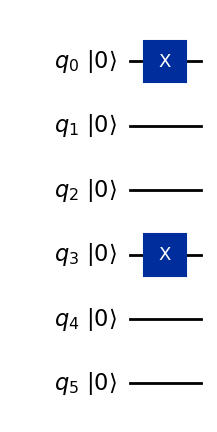

In [25]:
from qiskit_nature.second_q.circuit.library import HartreeFock

hf_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
hf_state.draw('mpl',initial_state=True)

Ce qui précède est une solution au **Devoir sur le Hamiltonien Qubit**.

* Définisons le solveur VQE.

In [28]:
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import VQE
import numpy as np


ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)
vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = np.zeros(ansatz.num_parameters) # Initialisation with zero-qubit

* Calcul et résultats

In [30]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# Résultats VQE
GS_VQE = GroundStateEigensolver(mapper, vqe_solver)
GS_res = GS_VQE.solve(problem)

In [31]:
# Resultats de la diagonalisation exacte
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

NP_calc = GroundStateEigensolver(mapper, numpy_solver)
NP_GS_res = NP_calc.solve(problem)

# Visualisation des résultats

In [32]:
au2kcalc = 627.503
error_VQE_NP = abs(GS_res.total_energies[0] - NP_GS_res.total_energies[0]) * au2kcalc
error_HF_NP = abs(GS_res.hartree_fock_energy - NP_GS_res.total_energies[0]) * au2kcalc

import pandas as pd

# Create the exact results dataframe
dict_res = {'Numpy': [NP_GS_res.total_energies[0], ''],
            'VQE': [GS_res.total_energies[0], error_VQE_NP],
            'HF': [GS_res.hartree_fock_energy, error_HF_NP]}
df = pd.DataFrame(dict_res, index = ['E_tot (H)', 'Error (kcal/mol)'])

df


,Numpy,VQE,HF
E_tot (H),-560.88044,-560.880213,-560.839162
Error (kcal/mol),,0.142458,25.901850


## Plugin `qiskit_nature_pyscf`

Nous allons maintenant utiliser le plugin `qiskit_nature_pyscf` qui couple PySCF et Qiskit Nature.  C'est un solveur [FCI](https://en.wikipedia.org/wiki/Full_configuration_interaction) (Full Configuration Interaction) basé sur Qiskit-Nature qui permet à un utilisateur de PySCF (Python-based Simulations of Chemistry Framework) de tirer parti des algorithmes quantique implémentés dans Qiskit-Nature pour être utilisés à la place de leurs homologues classiques (dans un esprit similaire à l'intégration NWChemEx).


### Class `qiskit_nature_pyscf.PySCFGroundStateSolver`

La classe `qiskit_nature.second_q.algorithms.GroundStateSolver` s'appuie sur le module ``fci`` de PySCF. Il n'utilise aucun algorithmes quantiques (puisqu'il les remplace dans le workflow de Qiskit-Naure) mais fournit à la place un utilitaire pour déboguer les workflows de calcul classique basés sur Qiskit-Nature. 

Plus important encore, il fournit une implémentation plus efficace de ce que Qiskit-Nature réalise en utilisant la classe `qiskit_algorithms.NumPyMinimumEigensolver` en combinaison avec un ``filter_criterion``. Pour les états fondamentaux de spin autres que le singlet, l'utilisation des composants Qiskit-Nature est beaucoup plus complexe, alors que cette classe fournit une alternative facile à utiliser.

In [33]:
from pyscf import fci
try: 
    from qiskit_nature_pyscf import PySCFGroundStateSolver
except:
    %pip install qiskit-nature-pyscf
    from qiskit_nature_pyscf import PySCFGroundStateSolver

In [38]:
solver_pyscf = PySCFGroundStateSolver(fci.direct_uhf.FCI())

result_pyscf = solver_pyscf.solve(problem)
print(result_pyscf)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -764.419565104202
  - computed part:      -3.079445017779
  - ActiveSpaceTransformer extracted energy part: -761.340120086423
~ Nuclear repulsion energy (Hartree): 203.539124974016
> Total ground state energy (Hartree): -560.880440130186
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000


In [40]:
print(f'error between the two exact calculations, {abs(result_pyscf.total_energies[0] - NP_GS_res.total_energies[0]) * au2kcalc} kcal/mol')

error between the two exact calculations, 0.0 kcal/mol
